In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import rcParams, cm
import scipy.constants as sc
import pandas as pd
from numba import njit
from astropy.io import fits
import os
rcParams["figure.figsize"] = (5,2)

In [2]:
@njit
def vel_gen(St0, u0, v0, dz, z_list, a):
    f_loc = v0**2/2
    f_list = [f_loc]
    u = u0 *  np.exp( 1/a * (1 - ( 1 + a*z_list**2 )**(-0.5) ) )
    
    for i in range(1, len(z_list)):
        v_loc = (2*f_loc)**0.5
        f_loc += dz * ( u0/St0 - v_loc/St0 * np.exp( -1/a * (1 - ( 1 + a*z_list[i-1]**2 )**(-0.5) ) ) - z_list[i-1] / (1 + a*z_list[i-1]**2)**(1.5))
        f_list.append(f_loc)
    
    f_list = np.array(f_list)
    v_list = ( 2*f_list )**0.5
    
    return z_list[:len(v_list)], v_list, u[:len(v_list)]

@njit
def vel_loop(St0, u0, v0, a, order, max_list_size, z_start, z_end):
    dz = 10**( np.log10(St0 * u0) - order )
    list_length = (z_end - z_start) / dz
    iter_total = np.ceil(list_length / max_list_size)
    print('Step size:', dz)
    print('Number of iterations:', iter_total)
        
    z_end_loc = z_start + dz * max_list_size
    v_loc = v0
    z_list = []
    v_list = []
    u_list = []

    for i in range(iter_total):
        z_list_loc = np.arange(z_start, z_end_loc, dz)
        z_list_loc, v_list_loc, u_list_loc = vel_gen(St0, u0, v_loc, dz, z_list_loc, a)
        
        z_start = z_end_loc + dz
        z_end_loc += dz * max_list_size + dz
        v_loc = v_list_loc[-1]
        
        z_list.extend(z_list_loc[::int(10*iter_total)])
        v_list.extend(v_list_loc[::int(10*iter_total)])
        u_list.extend(u_list_loc[::int(10*iter_total)])

        if (np.isnan(v_loc)):
            print('Number of actual iterations:', i)
            break
        
    return z_list, v_list, u_list

In [23]:
R = 1 # in au
a = 1e-4 # cm
v0 = 0.
order = 2
max_array_size = 5e8

Omega = (np.sqrt(sc.G * 2e30) * 1.5e11**(-1.5)) * R**(-1.5)
c_s = 1.5 * R**(-0.25) # in km/s
sdot = 2e-12 * (R/10)**(-1.5) # in g/cm2/s
sd = 30 * (1/R) # in g/cm2
rhos = 3.5 # in g/cm3

H_R = c_s / Omega / (1.5e8) / R
eta = H_R**2
St0 = np.sqrt(2*np.pi)* a * rhos / sd
u0 = np.sqrt(2*np.pi) / Omega * sdot / sd

Stb = St0 / u0
H_c_s = 5e6 / (3600*24*365) * R**1.5 # in yr

print('eta:', eta)
print('St_0:', St0)
print('St_b:', Stb)
print('u0:', u0)
print('max_z:', 1/Stb)
print('T:', H_c_s)

print('Array size:', f'{10**order / (St0**2):.2e}')
print('No iterations:', np.ceil(10**order / (St0**2) / max_array_size))

eta: 0.002528355033486658
St_0: 2.9243996537361668e-05
St_b: 1.1005734195644796
u0: 2.657159987466728e-05
max_z: 0.908617255535502
T: 0.15854895991882292
Array size: 1.17e+11
No iterations: 234.0


In [24]:
zl, vl, ul = vel_loop(St0, u0, v0, eta, order, max_array_size, 0, 10)

Step size: 7.770597747269288e-12
Number of iterations: 2574.0
Number of actual iterations: 234


In [25]:
data_fits = fits.PrimaryHDU(data=np.array([zl[::10], vl[::10], ul[::10]]))
data_fits.header['a'] = a
data_fits.header['a_units'] = 'cm'
data_fits.header['R'] = R
data_fits.header['R_units'] = 'au'
data_fits.header['ST0'] = St0
data_fits.header['STB'] = Stb
hdul = fits.HDUList([data_fits])
hdul.writeto('/data/jhyl3/vel_fits/1-4cm_radial/r'+str(R)+'a1-4cm.fits', overwrite=True)

In [ ]:
R_list = np.arange(10, 110, 10)

In [ ]:
for R in R_list:
    a = 1e-1 # cm
    v0 = 0.
    order = 2
    max_array_size = 5e8

    Omega = (np.sqrt(sc.G * 2e30) * 1.5e11**(-1.5)) * R**(-1.5)
    c_s = 1.5 * R**(-0.25) # in km/s
    sdot = 2e-12 * (R/10)**(-1.5) # in g/cm2/s
    sd = 30 * (1/R) # in g/cm2
    rhos = 3.5 # in g/cm3

    H_R = c_s / Omega / (1.5e8) / R
    eta = H_R**2
    St0 = np.sqrt(2*np.pi)* a * rhos / sd
    u0 = np.sqrt(2*np.pi) / Omega * sdot / sd

    Stb = St0 / u0
    H_c_s = 5e6 / (3600*24*365) * R**1.5 # in yr

    zl, vl, ul = vel_loop(St0, u0, v0, eta, order, max_array_size, 0, 10)

    data_fits = fits.PrimaryHDU(data=np.array([zl[::10], vl[::10], ul[::10]]))
    data_fits.header['a'] = a
    data_fits.header['a_units'] = 'cm'
    data_fits.header['R'] = R
    data_fits.header['R_units'] = 'au'
    data_fits.header['ST0'] = St0
    data_fits.header['STB'] = Stb
    hdul = fits.HDUList([data_fits])
    hdul.writeto('/data/jhyl3/vel_fits/1-1cm_radial/r'+str(R)+'a1-1cm.fits', overwrite=True)
    

(0.0, 2.9035307819504043e-05)

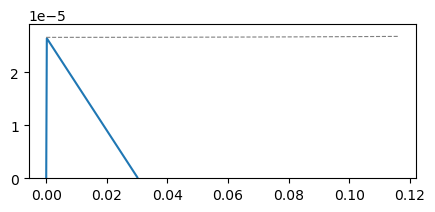

In [9]:
plt.plot(zl[::1000], vl[::1000])
plt.plot(zl[::10000], ul[::10000], c='gray', ls='--', lw=0.8)
plt.ylim(0,np.nanmax(vl[::1000])*1.1)

In [ ]:
v0 = np.logspace(-5,-2, 4)
run_1 = vel_loop(St0, u0, v0[0], eta, order, 1e5, 0, 2e-5)
run_2 = vel_loop(St0, u0, v0[1], eta, order, 1e5, 0, 2e-5)
run_3 = vel_loop(St0, u0, v0[2], eta, order, 1e5, 0, 2e-5)
run_4 = vel_loop(St0, u0, v0[3], eta, order, 1e5, 0, 2e-5)

In [ ]:
rcParams['figure.figsize'] = (4,2)
color = cm.viridis(np.linspace(1, 0, len(v0)))

step=1

plt.plot(run_1[0], run_1[2], c='C7', ls='--', lw=0.8)
plt.plot(run_1[0], run_1[1], c=color[0], label='$v_0=\,$'+f'{v0[0]:.0e}')
plt.plot(run_2[0], run_2[1], c=color[1], label='$v_0=\,$'+f'{v0[1]:.0e}')
plt.plot(run_3[0], run_3[1], c=color[2], label='$v_0=\,$'+f'{v0[2]:.0e}')
plt.plot(run_4[0], run_4[1], c=color[3], label='$v_0=\,$'+f'{v0[3]:.0e}')

plt.xlim(0,5e-6)
plt.yscale('log')
plt.ylim(1e-4,1e-1)
plt.xlabel('$z$ / $H$')
plt.ylabel('$v$ / $c_s$')
plt.title('$a=0.3\,\\mathrm{\mu m}$ at $30\,\\mathrm{au}$', fontsize=9)
plt.legend(prop={'size':9})
plt.savefig('graphics/3-5cm_30au_v0.png', dpi=300, bbox_inches='tight')

In [ ]:
v0 = np.logspace(-5,-1, 4)
list_size = 1e6
max_z = 1e-3
run_1 = vel_loop(St0, u0, v0[0], eta, order, list_size, 0, max_z)
run_2 = vel_loop(St0, u0, v0[1], eta, order, list_size, 0, max_z)
run_3 = vel_loop(St0, u0, v0[2], eta, order, list_size, 0, max_z)
run_4 = vel_loop(St0, u0, v0[3], eta, order, list_size, 0, max_z)

In [ ]:
plt.plot(run_1[0], run_1[2], c='C7', ls='--', lw=0.8)
plt.plot(run_1[0], run_1[1], c=color[0], label='$v_0=\,$'+f'{v0[0]:.0e}')
plt.plot(run_2[0], run_2[1], c=color[1], label='$v_0=\,$'+f'{v0[1]:.0e}')
plt.plot(run_3[0], run_3[1], c=color[2], label='$v_0=\,$'+f'{v0[2]:.0e}')
plt.plot(run_4[0], run_4[1], c=color[3], label='$v_0=\,$'+f'{v0[3]:.0e}')
plt.xlim(0,1e-4)
plt.yscale('log')
plt.ylim(1e-4,1e-0)
plt.xlabel('$z$ / $H$')
plt.ylabel('$v$ / $c_s$')